<a href="https://colab.research.google.com/github/vaidika1410/Satellite-Image-Steganography-Model/blob/main/Satellite_Steganography_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install tensorflow tensorflow-datasets --quiet


Dataset loaded: tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='/root/tensorflow_datasets/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    })

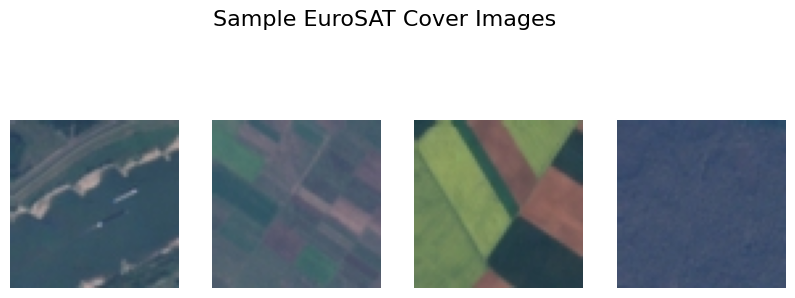

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the EuroSAT RGB dataset
dataset, info = tfds.load('eurosat/rgb', split='train', with_info=True, as_supervised=False)
print("Dataset loaded:", info)

# Normalize images to [0,1]
def preprocess_image(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.0
    return image

images_ds = dataset.map(preprocess_image).cache().shuffle(1000).batch(1)

# Display a few images
plt.figure(figsize=(10, 4))
for i, image in enumerate(images_ds.take(4)):
    plt.subplot(1, 4, i+1)
    plt.imshow(image[0])
    plt.axis("off")
plt.suptitle("Sample EuroSAT Cover Images", fontsize=16)
plt.show()


Sample Secret Message (binary): [1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0
 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1
 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1]


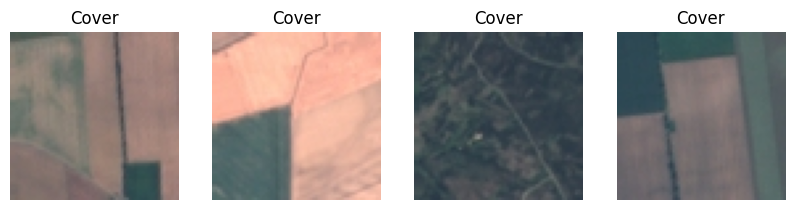

In [6]:
import numpy as np

# Number of samples you want to use
NUM_SAMPLES = 5000

# Truncate the image dataset
images_ds = images_ds.take(NUM_SAMPLES)

# Create 100-bit binary messages (secrets)
secret_bits = np.random.randint(0, 2, size=(NUM_SAMPLES, 100)).astype(np.float32)

# Convert secret messages to TensorFlow dataset
secrets_ds = tf.data.Dataset.from_tensor_slices(secret_bits)

# Pair cover image with secret
def create_sample(cover_img, secret_msg):
    return {
        "cover": tf.squeeze(cover_img, axis=0),
        "secret": secret_msg
    }

# Zip and preprocess the dataset
combined_ds = tf.data.Dataset.zip((images_ds, secrets_ds)).map(create_sample).batch(8).prefetch(tf.data.AUTOTUNE)

# Show sample images and their secret
for batch in combined_ds.take(1):
    plt.figure(figsize=(10, 4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(batch["cover"][i])
        plt.title("Cover")
        plt.axis("off")
    print("Sample Secret Message (binary):", batch["secret"][0].numpy().astype(int))
    plt.show()


In [7]:
from tensorflow.keras import layers, Model, Input
import tensorflow as tf

def compute_texture_mask(cover_input, threshold=0.2):
    # Convert to grayscale
    gray = tf.image.rgb_to_grayscale(cover_input)

    # Sobel edges
    sobel = tf.image.sobel_edges(gray)
    edge_magnitude = tf.sqrt(tf.reduce_sum(tf.square(sobel), axis=-1))  # shape: (batch, 64, 64, 1)

    # Normalize
    max_val = tf.reduce_max(edge_magnitude, axis=[1, 2, 3], keepdims=True)
    norm_edges = edge_magnitude / (max_val + 1e-8)

    # Binary mask
    mask = tf.cast(norm_edges > threshold, tf.float32)
    return mask

# Input layers
cover_input = Input(shape=(64, 64, 3), name='cover_input')
secret_input = Input(shape=(100,), name='secret_input')

# Expand secret
secret_expanded = layers.Dense(64 * 64)(secret_input)
secret_reshaped = layers.Reshape((64, 64, 1))(secret_expanded)

# Concatenate with cover
x = layers.Concatenate()([cover_input, secret_reshaped])

# CNN layers
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
delta = layers.Conv2D(3, (3, 3), padding='same', activation='tanh')(x)  # delta = change to apply

# Lambda layer for adaptive embedding using the texture mask
def apply_mask(inputs):
    cover, delta = inputs
    mask = compute_texture_mask(cover)
    return cover + mask * delta  # embed only where mask == 1

# Output stego image
stego = layers.Lambda(apply_mask, name='adaptive_embed')([cover_input, delta])

# Final encoder model
encoder_model = Model(inputs=[cover_input, secret_input], outputs=stego, name='secure_encoder')
encoder_model.compile(optimizer='adam', loss='mse')
encoder_model.summary()


Model: "secure_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ secret_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4096)      │    413,696 │ secret_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cover_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 64, 1) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64, 4) │          0 │ cover_input[0][0… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,184 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,464 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64, 3) │        867 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adaptive_embed      │ (None, 64, 64, 3) │          0 │ cover_input[0][0… │
│ (Lambda)            │                   │            │ conv2d_3[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 452,707 (1.73 MB)

 Trainable params: 452,707 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Step 1: Load EuroSAT satellite dataset
eurosat = tfds.load('eurosat', split='train', as_supervised=False)

# Step 2: Normalize and resize
def preprocess(sample):
    image = tf.image.resize(sample['image'], (64, 64))
    image = tf.cast(image, tf.float32) / 255.0  # normalize
    return image

eurosat_images = eurosat.map(preprocess)
NUM_SAMPLES = 1000  # Use subset for training/testing

# Take first N samples
eurosat_images = eurosat_images.take(NUM_SAMPLES)

# Step 3: Generate random secret vectors
secret_vectors = tf.random.uniform((NUM_SAMPLES, 100), minval=0, maxval=1, dtype=tf.float32)
secret_ds = tf.data.Dataset.from_tensor_slices(secret_vectors)

# Step 4: Combine cover + secret into a single dataset
def create_sample(img, secret):
    return {
        "cover": img,
        "secret": secret
    }

combined = tf.data.Dataset.zip((eurosat_images, secret_ds)).map(create_sample)


In [9]:
# Format for model input
def format_sample(sample):
    return (
        {
            "cover_input": sample['cover'],
            "secret_input": sample['secret']
        },
        sample['cover']  # Output should still look like the original image
    )

train_dataset = combined.map(format_sample).batch(8).prefetch(tf.data.AUTOTUNE)


In [10]:
encoder_model.fit(
    train_dataset,
    epochs=20,
    verbose=1
)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 261ms/step - loss: 1.3306e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 1.4309e-06
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - loss: 6.6892e-07
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - loss: 8.7501e-07
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 1.4820e-07
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - loss: 2.1783e-09
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - loss: 1.0801e-09
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - loss: 6.8982e-10
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - loss: 4.8599e-10
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - loss: 3.6261e-10
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - loss: 2.8178e-10
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - loss: 2.2546e-10
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - loss: 1.8467e-10
Epoch 14/20
125/125 ━━━━━━━━━━━━━━

In [11]:
loss = encoder_model.evaluate(train_dataset)
print(f"Reconstruction Loss (MSE): {loss:.4f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 6.0583e-11
Reconstruction Loss (MSE): 0.0000


In [12]:
import tensorflow as tf
import numpy as np

def compute_psnr(original, stego):
    psnr = tf.image.psnr(original, stego, max_val=1.0)
    return tf.reduce_mean(psnr).numpy()

# Generate a batch of test samples
for sample in combined_ds.take(1):
    test_cover = tf.expand_dims(sample['cover'][0], axis=0)
    test_secret = tf.expand_dims(sample['secret'][0], axis=0)

    stego_image = encoder_model.predict({
        "cover_input": test_cover,
        "secret_input": test_secret
    })

    psnr_value = compute_psnr(test_cover, stego_image)
    print(f"PSNR between Cover and Stego Image: {psnr_value:.2f} dB")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
PSNR between Cover and Stego Image: 92.06 dB


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


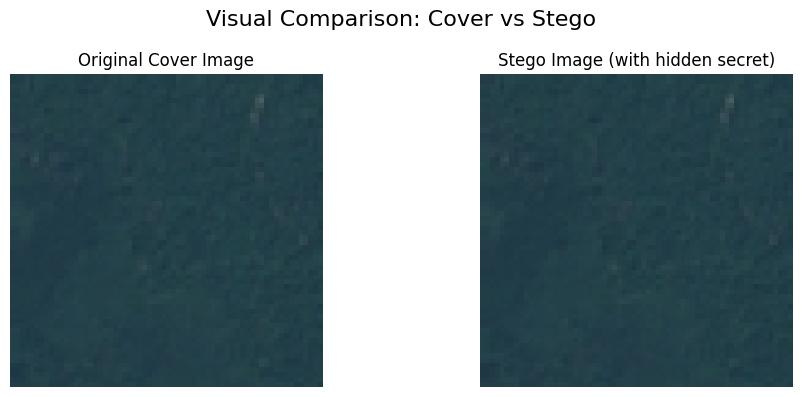

In [13]:
import matplotlib.pyplot as plt

# Get one test sample
for sample in combined.take(1):
    test_cover = tf.expand_dims(sample['cover'], axis=0)   # Shape: (1, 64, 64, 3)
    test_secret = tf.expand_dims(sample['secret'], axis=0) # Shape: (1, 100)
    break

# Generate the stego image
stego_image = encoder_model.predict({
    "cover_input": test_cover,
    "secret_input": test_secret
})

# Plot original vs stego
plt.figure(figsize=(10, 4))

# Original Cover
plt.subplot(1, 2, 1)
plt.imshow(test_cover[0])
plt.title("Original Cover Image")
plt.axis('off')

# Stego Image
plt.subplot(1, 2, 2)
plt.imshow(stego_image[0])
plt.title("Stego Image (with hidden secret)")
plt.axis('off')

plt.suptitle("Visual Comparison: Cover vs Stego", fontsize=16)
plt.tight_layout()
plt.show()


In [14]:
from tensorflow.keras import layers, Model, Input

# Decoder input is a stego image (same shape as cover)
stego_input = Input(shape=(64, 64, 3), name='stego_input')

# CNN layers to extract features
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(stego_input)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.Flatten()(x)

# Output layer to produce 100-bit secret
decoded_secret = layers.Dense(100, activation='sigmoid')(x)

# Build the model
decoder_model = Model(inputs=stego_input, outputs=decoded_secret, name='decoder')
decoder_model.compile(optimizer='adam', loss='mse')

# Summary
decoder_model.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ stego_input (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │    26,214,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,233,892 (100.07 MB)

 Trainable params: 26,233,892 (100.07 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
import numpy as np
import tensorflow as tf

# Rebuild stego → secret dataset manually (safe and shape-stable)

stego_list = []
secret_list = []

# Limit to 500–1000 for practical GPU usage
for sample in combined.take(500):
    cover = tf.expand_dims(sample['cover'], axis=0)
    secret = tf.expand_dims(sample['secret'], axis=0)

    # Predict stego image using trained encoder
    stego = encoder_model.predict({
        "cover_input": cover,
        "secret_input": secret
    }, verbose=0)[0]

    stego_list.append(stego)
    secret_list.append(secret.numpy()[0])

# Convert to tensors
stego_tensor = tf.convert_to_tensor(stego_list, dtype=tf.float32)
secret_tensor = tf.convert_to_tensor(secret_list, dtype=tf.float32)

# Create decoder training dataset
decoder_train_ds = tf.data.Dataset.from_tensor_slices((stego_tensor, secret_tensor))
decoder_train_ds = decoder_train_ds.batch(8).prefetch(tf.data.AUTOTUNE)


In [16]:
decoder_model.fit(
    decoder_train_ds,
    epochs=50,
    verbose=1
)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step - loss: 0.1579
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - loss: 0.0826
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 353ms/step - loss: 0.0825
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 286ms/step - loss: 0.0825
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step - loss: 0.0824
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 280ms/step - loss: 0.0825
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 288ms/step - loss: 0.0824
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 285ms/step - loss: 0.0814
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 287ms/step - loss: 0.0824
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - loss: 0.0824
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - loss: 0.0824
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - loss: 0.0824
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 280ms/step - loss: 0.0817
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 320ms/step - loss: 0.0792
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 

In [17]:
decoder_model.compile(optimizer='adam', loss='binary_crossentropy')


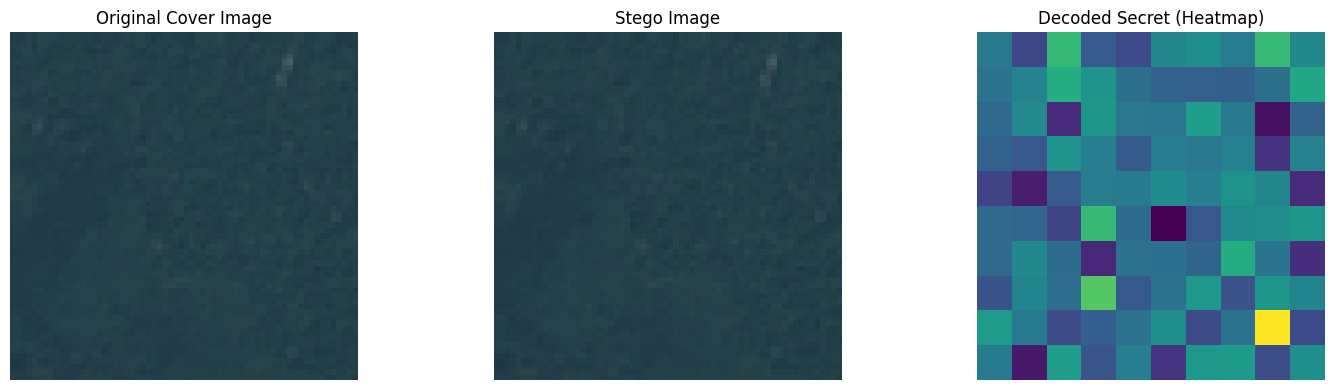

Original Secret Vector:
 [1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0]
Decoded Secret Vector:
 [1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1]


In [18]:
import matplotlib.pyplot as plt

# Get one test sample from the combined dataset
for sample in combined.take(1):
    test_cover = tf.expand_dims(sample['cover'], axis=0)
    test_secret = tf.expand_dims(sample['secret'], axis=0)
    break

# Generate stego image using encoder
stego = encoder_model.predict({
    "cover_input": test_cover,
    "secret_input": test_secret
}, verbose=0)

# Decode the secret using decoder
decoded_secret = decoder_model.predict(stego, verbose=0)

# Reshape for visualization
original_secret_map = tf.reshape(test_secret[0], (10, 10))
decoded_secret_map = tf.reshape(decoded_secret[0], (10, 10))

# Plotting
plt.figure(figsize=(15, 4))

# Original Cover Image
plt.subplot(1, 3, 1)
plt.imshow(test_cover[0])
plt.title("Original Cover Image")
plt.axis('off')

# Stego Image
plt.subplot(1, 3, 2)
plt.imshow(stego[0])
plt.title("Stego Image")
plt.axis('off')

# Secret Comparison (Heatmaps)
plt.subplot(1, 3, 3)
plt.imshow(decoded_secret_map, cmap='viridis')
plt.title("Decoded Secret (Heatmap)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Print decoded vs original vectors (rounded to 0/1)
print("Original Secret Vector:\n", tf.round(test_secret[0][:20]).numpy().astype(int))
print("Decoded Secret Vector:\n", tf.round(decoded_secret[0][:20]).numpy().astype(int))


In [19]:
def bit_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.round(y_true), tf.round(y_pred)), tf.float32))

decoder_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[bit_accuracy])


In [20]:
import tensorflow as tf
import numpy as np

# PSNR between Cover and Stego
def compute_psnr(original, stego):
    psnr = tf.image.psnr(original, stego, max_val=1.0)
    return tf.reduce_mean(psnr).numpy()

# Bitwise Accuracy between Original and Decoded Secret
def compute_bit_accuracy(original, decoded, threshold=0.5):
    # Round both vectors to 0 or 1
    original_bits = tf.round(original).numpy().astype(int)
    decoded_bits = tf.round(decoded).numpy().astype(int)

    # Compare bits
    matches = np.sum(original_bits == decoded_bits)
    total_bits = len(original_bits.flatten())
    bit_accuracy = matches / total_bits

    return bit_accuracy, matches, total_bits, original_bits, decoded_bits

# Take 1 test sample (already using 'combined')
for sample in combined.take(1):
    test_cover = tf.expand_dims(sample['cover'], axis=0)
    test_secret = tf.expand_dims(sample['secret'], axis=0)
    break

# Generate Stego Image
stego = encoder_model.predict({
    "cover_input": test_cover,
    "secret_input": test_secret
}, verbose=0)

# Decode the Secret
decoded_secret = decoder_model.predict(stego, verbose=0)

# Evaluate PSNR and Bitwise Accuracy
psnr_value = compute_psnr(test_cover, stego)
bit_accuracy, matches, total_bits, original_bits, decoded_bits = compute_bit_accuracy(test_secret[0], decoded_secret[0])

# Print results
print(f"🔐 Bitwise Accuracy: {bit_accuracy * 100:.2f}%")
print(f"🖼️  PSNR between Cover and Stego Image: {psnr_value:.2f} dB")
print("Original Secret Bits: ", original_bits[:20])
print("Decoded  Secret Bits: ", decoded_bits[:20])
print(f"\n✅ Bitwise Accuracy: {bit_accuracy * 100:.2f}% ({matches}/{total_bits} bits matched)")


🔐 Bitwise Accuracy: 65.00%
🖼️  PSNR between Cover and Stego Image: 147.16 dB
Original Secret Bits:  [1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0]
Decoded  Secret Bits:  [1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1]

✅ Bitwise Accuracy: 65.00% (65/100 bits matched)


In [21]:
# How accurately did the decoder recover the secret bits that were originally embedded into the cover image?

import numpy as np

# Round both vectors to 0 or 1
original_bits = tf.round(test_secret[0]).numpy().astype(int)
decoded_bits = tf.round(decoded_secret[0]).numpy().astype(int)

# Compare bits
matches = np.sum(original_bits == decoded_bits)
total_bits = len(original_bits)

# Accuracy
bit_accuracy = matches / total_bits

print("Original Secret Bits: ", original_bits[:20])
print("Decoded  Secret Bits: ", decoded_bits[:20])
print(f"\n✅ Bitwise Accuracy: {bit_accuracy * 100:.2f}% ({matches}/{total_bits} bits matched)")


Original Secret Bits:  [1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0]
Decoded  Secret Bits:  [1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1]

✅ Bitwise Accuracy: 65.00% (65/100 bits matched)


In [22]:
# Save encoder
encoder_model.save("encoder_model.keras")

# Save decoder
decoder_model.save("decoder_model.keras")


In [23]:
# building the detector dataset - binary classified data having 0 as normal image (EuroSAT img) and 1 as stego image (recieved )

In [24]:
normal_images = []
stego_images = []
labels = []

# Generate 500 samples (adjust as needed)
for sample in combined.take(500):
    cover = tf.expand_dims(sample['cover'], axis=0)
    secret = tf.expand_dims(sample['secret'], axis=0)

    # 1. Add normal cover image (label 0)
    normal_images.append(sample['cover'].numpy())
    labels.append(0)

    # 2. Generate and add stego image (label 1)
    stego = encoder_model.predict({
        "cover_input": cover,
        "secret_input": secret
    }, verbose=0)[0]
    stego_images.append(stego)
    labels.append(1)


In [25]:
import numpy as np
import tensorflow as tf

# Combine both
X = np.array(normal_images + stego_images)
y = np.array(labels)

# Shuffle
indices = np.arange(len(X))
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

# Split into train and test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [26]:
# Detector using CNN

from tensorflow.keras import layers, models

# Define model
detector_model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

detector_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

detector_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,081 (4.36 MB)

 Trainable params: 1,142,081 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Convert to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1000).batch(16).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(16).prefetch(tf.data.AUTOTUNE)


In [28]:
history = detector_model.fit(
    train_ds,
    epochs=80,
    validation_data=test_ds,
    verbose=1
)


Epoch 1/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.5011 - loss: 0.7116 - val_accuracy: 0.4350 - val_loss: 0.6944
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.5316 - loss: 0.6939 - val_accuracy: 0.4350 - val_loss: 0.6936
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.5469 - loss: 0.6927 - val_accuracy: 0.4350 - val_loss: 0.6950
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.5389 - loss: 0.6925 - val_accuracy: 0.4350 - val_loss: 0.7024
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.4823 - loss: 0.6969 - val_accuracy: 0.4350 - val_loss: 0.6986
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.5012 - loss: 0.6934 - val_accuracy: 0.4350 - val_loss: 0.6956
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.5098 - loss: 0.6925 - val_accuracy: 0.4350 - val_loss: 0.7030
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.5276 - loss: 0.6980 - val_accuracy: 0.4350 - 

In [29]:
loss, acc = detector_model.evaluate(test_ds, verbose=0)
print(f"\n✅ Detector Accuracy on Test Set: {acc * 100:.2f}%")



✅ Detector Accuracy on Test Set: 92.50%


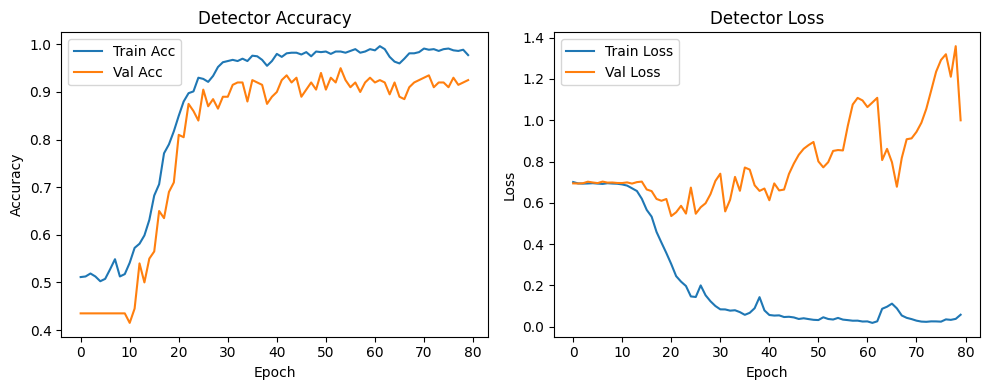

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Detector Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Detector Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [31]:
# save detector

detector_model.save("detector_model.keras")

In [32]:
import tensorflow as tf

def compute_texture_mask(image, threshold=0.2):
    # Convert to grayscale (approximate)
    gray = tf.image.rgb_to_grayscale(image)

    # Compute Sobel edges
    sobel = tf.image.sobel_edges(gray)
    edge_magnitude = tf.sqrt(tf.reduce_sum(tf.square(sobel), axis=-1))  # shape: (H, W, 1)

    # Normalize
    norm_edges = edge_magnitude / tf.reduce_max(edge_magnitude)

    # Binary mask: 1 where texture is high, 0 where low
    mask = tf.cast(norm_edges > threshold, tf.float32)

    return mask  # shape: (H, W, 1)


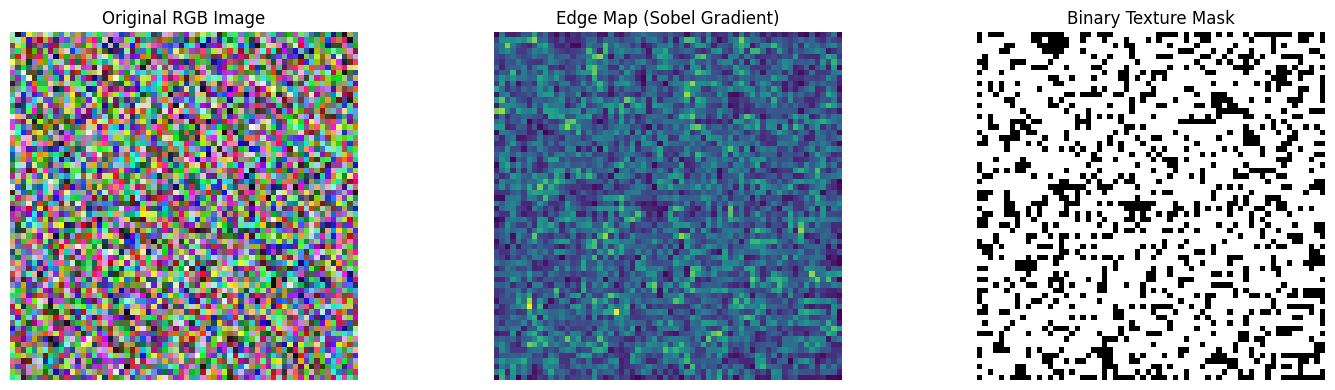

In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Dummy RGB image (replace this with your actual image of shape [64, 64, 3])
image = tf.random.uniform((64, 64, 3), minval=0, maxval=1, dtype=tf.float32)

def compute_texture_mask(image, threshold=0.2):
    # Ensure 4D for sobel
    image = tf.expand_dims(image, axis=0)  # shape becomes (1, 64, 64, 3)

    # Convert to grayscale
    gray = tf.image.rgb_to_grayscale(image)  # shape: (1, 64, 64, 1)

    # Sobel edge detection
    sobel = tf.image.sobel_edges(gray)  # shape: (1, 64, 64, 1, 2)
    sobel = tf.squeeze(sobel, axis=0)   # remove batch dim
    edge_magnitude = tf.sqrt(tf.reduce_sum(tf.square(sobel), axis=-1))  # shape: (64, 64, 1)

    # Normalize
    edge_magnitude = tf.squeeze(edge_magnitude)  # shape: (64, 64)
    norm_edges = edge_magnitude / (tf.reduce_max(edge_magnitude) + 1e-8)

    # Texture mask
    mask = tf.cast(norm_edges > threshold, tf.float32)

    return norm_edges, mask

# Apply
edge_map, texture_mask = compute_texture_mask(image)

# Plotting
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original RGB Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edge_map, cmap='viridis')
plt.title("Edge Map (Sobel Gradient)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(texture_mask, cmap='gray')
plt.title("Binary Texture Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [34]:
def build_encoder_model(secret_length):
    from tensorflow.keras import layers, Model

    # Cover image input
    cover_input = layers.Input(shape=(64, 64, 3), name="cover_input")

    # Secret vector input
    secret_input = layers.Input(shape=(secret_length,), name="secret_input")

    # Expand secret to match spatial dimensions
    secret_expanded = layers.Dense(64 * 64 * 1, activation='relu')(secret_input)
    secret_reshaped = layers.Reshape((64, 64, 1))(secret_expanded)

    # Concatenate with cover
    x = layers.Concatenate()([cover_input, secret_reshaped])

    # Convolutional encoding
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    stego_output = layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid', name="stego_output")(x)

    return Model(inputs=[cover_input, secret_input], outputs=stego_output, name="Encoder_Payload")


In [35]:
def build_decoder_model(secret_length):
    from tensorflow.keras import layers, Model

    # Input: Stego image
    stego_input = layers.Input(shape=(64, 64, 3), name="stego_input")

    # Convolutional decoding
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(stego_input)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    decoded_output = layers.Dense(secret_length, activation='sigmoid', name="decoded_secret")(x)

    return Model(inputs=stego_input, outputs=decoded_output, name="Decoder_Payload")


In [36]:
# Shuffle before splitting
combined = combined.shuffle(buffer_size=NUM_SAMPLES, seed=42)

# Split sizes
val_size = int(0.2 * NUM_SAMPLES)  # 20% = 200
train_size = NUM_SAMPLES - val_size  # 80% = 800

# Create validation dataset
val_dataset = combined.take(val_size).batch(1)

# (Optional) Create training dataset
train_dataset = combined.skip(val_size).batch(1)


In [37]:
# NEW payload-boosted dataset (separate)
SECRET_LENGTH_PAYLOAD = 256  # or 512, 1024 later
secret_vectors_payload = tf.random.uniform((NUM_SAMPLES, SECRET_LENGTH_PAYLOAD), minval=0, maxval=1, dtype=tf.float32)
secret_ds_payload = tf.data.Dataset.from_tensor_slices(secret_vectors_payload)

# Reuse same cover images
eurosat_images_payload = tfds.load('eurosat', split='train', as_supervised=False)
eurosat_images_payload = eurosat_images_payload.map(preprocess).take(NUM_SAMPLES)

# Create new combined payload dataset
def create_payload_sample(img, secret):
    return {
        "cover": img,
        "secret": secret
    }

combined_payload = tf.data.Dataset.zip((eurosat_images_payload, secret_ds_payload)).map(create_payload_sample)
combined_payload = combined_payload.shuffle(buffer_size=NUM_SAMPLES, seed=999)

# Split into validation for payload experiment
val_dataset_payload = combined_payload.take(200).batch(1)


In [38]:
encoder_payload = build_encoder_model(secret_length=256)
decoder_payload = build_decoder_model(secret_length=256)


In [39]:
import numpy as np
from sklearn.metrics import accuracy_score

# Initialize metric lists
encoder_psnrs = []
encoder_mses = []
decoder_accuracies = []
true_labels = []
pred_labels = []

# Loop through validation set
for sample in val_dataset:
    val_cover = sample['cover']
    val_secret = sample['secret']

    # --- Encode ---
    val_stego = encoder_model.predict({
        "cover_input": val_cover,
        "secret_input": val_secret
    }, verbose=0)

    # --- Decoder Evaluation ---
    val_decoded = decoder_model.predict(val_stego, verbose=0)

    orig = tf.round(val_secret[0]).numpy().astype(int).flatten()
    pred = tf.round(val_decoded[0]).numpy().astype(int).flatten()
    acc = np.mean(orig == pred)
    decoder_accuracies.append(acc)

    # --- Encoder Evaluation (Cover vs Stego) ---
    psnr = tf.image.psnr(val_cover, val_stego, max_val=1.0).numpy()[0]
    mse = tf.reduce_mean(tf.square(val_cover - val_stego)).numpy()
    encoder_psnrs.append(psnr)
    encoder_mses.append(mse)

    # --- Detector Evaluation (Cover = 0, Stego = 1) ---
    cover_pred = detector_model.predict(val_cover, verbose=0)
    pred_labels.append(np.round(cover_pred[0][0]))
    true_labels.append(0)

    stego_pred = detector_model.predict(val_stego, verbose=0)
    pred_labels.append(np.round(stego_pred[0][0]))
    true_labels.append(1)

# === Final Results ===

print(f"\n📊 Validation Results:")
print(f"🧠 Decoder Bitwise Accuracy: {np.mean(decoder_accuracies) * 100:.2f}%")
print(f"🖼️  Encoder PSNR (Cover vs Stego): {np.mean(encoder_psnrs):.2f} dB")
print(f"🧮 Encoder MSE (Cover vs Stego): {np.mean(encoder_mses):.6f}")
print(f"🛡️  Detector Accuracy (Cover vs Stego): {accuracy_score(true_labels, pred_labels) * 100:.2f}%")



📊 Validation Results:
🧠 Decoder Bitwise Accuracy: 67.72%
🖼️  Encoder PSNR (Cover vs Stego): 125.72 dB
🧮 Encoder MSE (Cover vs Stego): 0.000000
🛡️  Detector Accuracy (Cover vs Stego): 50.00%


In [40]:
import tensorflow as tf

def payload_fidelity_loss(secret_true, secret_pred):
    # Binary cross-entropy loss (can also try MSE)
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(secret_true, secret_pred)


In [41]:
def combined_loss_fn(cover_true, stego_pred, secret_true, decoded_pred, alpha=1.0):
    # Encoder loss: how close stego is to cover
    image_loss = tf.reduce_mean(tf.square(cover_true - stego_pred))  # MSE

    # Decoder loss: how close decoded secret is to original
    payload_loss = payload_fidelity_loss(secret_true, decoded_pred)

    # Total loss = image distortion + payload fidelity
    return image_loss + alpha * payload_loss


In [42]:
import numpy as np
from sklearn.metrics import accuracy_score

# === Helper function ===
def evaluate_encoder_decoder(dataset, encoder, decoder, secret_length, label=""):
    psnrs = []
    mses = []
    accuracies = []

    for sample in dataset:
        cover = sample['cover']
        secret = sample['secret']

        # Encode
        stego = encoder.predict({
            "cover_input": cover,
            "secret_input": secret
        }, verbose=0)

        # Decode
        decoded = decoder.predict(stego, verbose=0)

        # Accuracy
        orig = tf.round(secret[0]).numpy().astype(int).flatten()
        pred = tf.round(decoded[0]).numpy().astype(int).flatten()
        acc = np.mean(orig == pred)
        accuracies.append(acc)

        # PSNR & MSE
        psnr = tf.image.psnr(cover, stego, max_val=1.0).numpy()[0]
        mse = tf.reduce_mean(tf.square(cover - stego)).numpy()
        psnrs.append(psnr)
        mses.append(mse)

    # Payload capacity in bpp
    bpp = secret_length / (64 * 64 * 3)

    # Print results
    print(f"\n📦 Results for {label}")
    print(f"🔐 Secret Length: {secret_length} bits")
    print(f"📏 Payload Capacity: {bpp:.4f} bpp")
    print(f"🖼️  Avg. PSNR: {np.mean(psnrs):.2f} dB")
    print(f"🧮 Avg. MSE: {np.mean(mses):.6f}")
    print(f"✅ Decoder Bit Accuracy: {np.mean(accuracies) * 100:.2f}%")

    return {
        "secret_length": secret_length,
        "bpp": bpp,
        "psnr": np.mean(psnrs),
        "mse": np.mean(mses),
        "accuracy": np.mean(accuracies)
    }


In [43]:
# 100-bit: Original model
results_100 = evaluate_encoder_decoder(
    dataset=val_dataset,
    encoder=encoder_model,
    decoder=decoder_model,
    secret_length=100,
    label="100-bit Original"
)

# 256-bit: Payload model
results_256 = evaluate_encoder_decoder(
    dataset=val_dataset_payload,
    encoder=encoder_payload,
    decoder=decoder_payload,
    secret_length=256,
    label="256-bit Payload"
)



📦 Results for 100-bit Original
🔐 Secret Length: 100 bits
📏 Payload Capacity: 0.0081 bpp
🖼️  Avg. PSNR: 129.57 dB
🧮 Avg. MSE: 0.000000
✅ Decoder Bit Accuracy: 70.53%

📦 Results for 256-bit Payload
🔐 Secret Length: 256 bits
📏 Payload Capacity: 0.0208 bpp
🖼️  Avg. PSNR: 14.96 dB
🧮 Avg. MSE: 0.041153
✅ Decoder Bit Accuracy: 50.01%


In [47]:
import tensorflow as tf

# Optimizers for payload encoder and decoder
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


In [48]:
BATCH_SIZE = 8  # You can try 8, 16, or 32 based on your GPU RAM

# Shuffle the payload dataset
combined_payload = combined_payload.shuffle(buffer_size=NUM_SAMPLES, seed=999)

# Split into train and validation
VAL_SIZE = int(0.2 * NUM_SAMPLES)  # 20% validation
TRAIN_SIZE = NUM_SAMPLES - VAL_SIZE

# Split
val_dataset_payload = combined_payload.take(VAL_SIZE)
train_dataset_payload = combined_payload.skip(VAL_SIZE)

# ⚡ Final efficient training pipeline
train_dataset_payload = (
    train_dataset_payload
    .cache()  # Cache in memory
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset_payload = (
    val_dataset_payload
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


for batch in train_dataset_payload:  # ✅ 256-bit secrets
    cover_input = batch['cover']
    secret_input = batch['secret']

    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        stego_pred = encoder_payload([cover_input, secret_input], training=True)
        decoded_pred = decoder_payload(stego_pred, training=True)

        # Loss
        loss = combined_loss_fn(
            cover_true=cover_input,
            stego_pred=stego_pred,
            secret_true=secret_input,
            decoded_pred=decoded_pred,
            alpha=1.0
        )

    # Backpropagation
    encoder_grads = tape.gradient(loss, encoder_payload.trainable_variables)
    decoder_grads = tape.gradient(loss, decoder_payload.trainable_variables)

    encoder_optimizer.apply_gradients(zip(encoder_grads, encoder_payload.trainable_variables))
    decoder_optimizer.apply_gradients(zip(decoder_grads, decoder_payload.trainable_variables))


In [49]:
# Example check
print(type(train_dataset_payload))


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [50]:
for batch in train_dataset_payload.take(1):
    print("Batch keys:", batch.keys())
    print("Cover shape:", batch['cover'].shape)
    print("Secret shape:", batch['secret'].shape)


Batch keys: dict_keys(['cover', 'secret'])
Cover shape: (8, 64, 64, 3)
Secret shape: (8, 256)


In [51]:
NUM_EPOCHS = 30  # ✅ Set number of training epochs

loss_history = []

for epoch in range(NUM_EPOCHS):
    epoch_loss = []

for batch in train_dataset_payload:
    try:
        cover_input = batch['cover']
        secret_input = batch['secret']
        print("📦 Cover shape:", cover_input.shape, "Secret shape:", secret_input.shape)

        with tf.GradientTape(persistent=True) as tape:
            stego_pred = encoder_payload([cover_input, secret_input], training=True)
            decoded_pred = decoder_payload(stego_pred, training=True)

            loss = combined_loss_fn(
                cover_true=cover_input,
                stego_pred=stego_pred,
                secret_true=secret_input,
                decoded_pred=decoded_pred,
                alpha=1.0
            )

        # Apply grads
        encoder_grads = tape.gradient(loss, encoder_payload.trainable_variables)
        decoder_grads = tape.gradient(loss, decoder_payload.trainable_variables)
        encoder_optimizer.apply_gradients(zip(encoder_grads, encoder_payload.trainable_variables))
        decoder_optimizer.apply_gradients(zip(decoder_grads, decoder_payload.trainable_variables))

        print("✅ Loss:", loss.numpy())
        break  # Just test 1 batch
    except Exception as e:
        print("❌ Error during training:", e)
        break


        epoch_loss.append(loss.numpy())

    avg_loss = sum(epoch_loss) / len(epoch_loss)
    loss_history.append(avg_loss)
    print(f"📉 Epoch {epoch+1}, Loss: {avg_loss:.6f}")


📦 Cover shape: (8, 64, 64, 3) Secret shape: (8, 256)
✅ Loss: 0.69650275


In [52]:
def build_encoder(input_shape_cover=(64, 64, 3), input_shape_secret=(256,)):
    cover_input = tf.keras.Input(shape=input_shape_cover)
    secret_input = tf.keras.Input(shape=input_shape_secret)

    # Expand secret to match image dimensions
    x_secret = tf.keras.layers.Dense(64*64, activation='relu')(secret_input)
    x_secret = tf.keras.layers.Reshape((64, 64, 1))(x_secret)

    # Combine cover and secret
    x = tf.keras.layers.Concatenate()([cover_input, x_secret])

    # Deep convolutional feature extraction
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(3, 1, activation='sigmoid', padding='same')(x)  # Stego output

    return tf.keras.Model(inputs=[cover_input, secret_input], outputs=x, name='encoder')


In [53]:
def build_decoder(input_shape_stego=(64, 64, 3), secret_length=256):
    stego_input = tf.keras.Input(shape=input_shape_stego)

    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(stego_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    secret_output = tf.keras.layers.Dense(secret_length, activation='sigmoid')(x)

    return tf.keras.Model(inputs=stego_input, outputs=secret_output, name='decoder')


In [54]:
def combined_loss_fn(cover_true, stego_pred, secret_true, decoded_pred, alpha=1.0, beta=2.0):
    # Image quality loss
    mse_loss = tf.reduce_mean(tf.square(cover_true - stego_pred))
    # Secret recovery loss
    bce_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(secret_true, decoded_pred))
    # Combine
    return alpha * mse_loss + beta * bce_loss


In [55]:
def decoder_bit_accuracy(secret_true, decoded_pred):
    decoded_bits = tf.round(decoded_pred)
    acc = tf.reduce_mean(tf.cast(tf.equal(decoded_bits, secret_true), tf.float32))
    return acc


In [60]:

train_dataset_payload = combined_payload.skip(VAL_SIZE)
train_dataset_payload = train_dataset_payload.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [61]:
for batch in train_dataset_payload.take(1):
    print("Cover shape:", batch['cover'].shape)
    print("Secret shape:", batch['secret'].shape)


Cover shape: (8, 64, 64, 3)
Secret shape: (8, 256)


In [63]:
print("🧪 DEBUG SHAPES:")
print("  Cover input shape:", cover_input.shape)
print("  Secret input shape:", secret_input.shape)


🧪 DEBUG SHAPES:
  Cover input shape: (8, 8, 64, 64, 3)
  Secret input shape: (8, 8, 256)


In [64]:
# Add safety reshape
cover_input = tf.reshape(cover_input, (-1, 64, 64, 3))
secret_input = tf.reshape(secret_input, (-1, 256))  # or 512 if using 512-bit


In [65]:
stego_pred = encoder_payload([cover_input, secret_input], training=True)


In [67]:
# ✅ Step 1: Dataset Setup (NO prior batching)
combined_payload = combined_payload.shuffle(buffer_size=NUM_SAMPLES, seed=999)

VAL_SIZE = int(0.2 * NUM_SAMPLES)
TRAIN_SIZE = NUM_SAMPLES - VAL_SIZE

val_dataset_payload = combined_payload.take(VAL_SIZE)
train_dataset_payload = combined_payload.skip(VAL_SIZE)

# ✅ Step 2: Apply batching and prefetch ONCE here
BATCH_SIZE = 8
train_dataset_payload = train_dataset_payload.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset_payload = val_dataset_payload.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ✅ Step 3: Training Loop
NUM_EPOCHS = 15
loss_history = []
acc_history = []

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=500,
    decay_rate=0.9
)

# Optimizers
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Ensure binary secrets
def ensure_binary_secret(secret_tensor):
    return tf.cast(tf.round(secret_tensor), tf.float32)

for epoch in range(NUM_EPOCHS):
    epoch_loss = []
    epoch_acc = []

    for step, batch in enumerate(train_dataset_payload):
        cover_input = batch['cover']
        secret_input = ensure_binary_secret(batch['secret'])

        # ✅ Confirm correct shape (debug only if needed)
        # print("Cover:", cover_input.shape, "Secret:", secret_input.shape)

        with tf.GradientTape(persistent=True) as tape:
            # Forward pass
            stego_pred = encoder_payload([cover_input, secret_input], training=True)
            decoded_pred = decoder_payload(stego_pred, training=True)

            # Loss calculation
            loss = combined_loss_fn(
                cover_true=cover_input,
                stego_pred=stego_pred,
                secret_true=secret_input,
                decoded_pred=decoded_pred,
                alpha=0.7,
                beta=2.0
            )

        # Backpropagation
        encoder_grads = tape.gradient(loss, encoder_payload.trainable_variables)
        decoder_grads = tape.gradient(loss, decoder_payload.trainable_variables)

        encoder_optimizer.apply_gradients(zip(encoder_grads, encoder_payload.trainable_variables))
        decoder_optimizer.apply_gradients(zip(decoder_grads, decoder_payload.trainable_variables))

        # Accuracy calculation
        decoded_bits = tf.round(decoded_pred)
        acc = tf.reduce_mean(tf.cast(tf.equal(decoded_bits, secret_input), tf.float32))

        # Track
        epoch_loss.append(loss.numpy())
        epoch_acc.append(acc.numpy())

        # 🔍 Debug Print in First Batch
        if epoch == 0 and step == 0:
            print("\n🔬 Debug - First Batch")
            print("Secret     :", secret_input.numpy()[0][:10])
            print("Decoded    :", decoded_pred.numpy()[0][:10])
            print("Rounded    :", decoded_bits.numpy()[0][:10])
            print("Accuracy   :", acc.numpy())

    # Average metrics for epoch
    avg_loss = sum(epoch_loss) / len(epoch_loss)
    avg_acc = sum(epoch_acc) / len(epoch_acc)
    loss_history.append(avg_loss)
    acc_history.append(avg_acc)

    print(f"📉 Epoch {epoch+1}, Loss: {avg_loss:.6f}, 🧠 Decoder Accuracy: {avg_acc*100:.2f}%")



🔬 Debug - First Batch
Secret     : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Decoded    : [0.21977696 0.26840374 0.1276936  0.49950525 0.85002977 0.14959575
 0.15971978 0.21973251 0.13522457 0.11793454]
Rounded    : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy   : 0.91748047
📉 Epoch 1, Loss: 0.570810, 🧠 Decoder Accuracy: 90.66%
📉 Epoch 2, Loss: 0.287333, 🧠 Decoder Accuracy: 96.38%
📉 Epoch 3, Loss: 0.136798, 🧠 Decoder Accuracy: 99.07%
📉 Epoch 4, Loss: 0.080903, 🧠 Decoder Accuracy: 99.72%
📉 Epoch 5, Loss: 0.053798, 🧠 Decoder Accuracy: 99.93%
📉 Epoch 6, Loss: 0.040964, 🧠 Decoder Accuracy: 99.98%
📉 Epoch 7, Loss: 0.032707, 🧠 Decoder Accuracy: 99.99%
📉 Epoch 8, Loss: 0.027845, 🧠 Decoder Accuracy: 99.98%
📉 Epoch 9, Loss: 0.024458, 🧠 Decoder Accuracy: 99.98%
📉 Epoch 10, Loss: 0.021208, 🧠 Decoder Accuracy: 99.98%
📉 Epoch 11, Loss: 0.021252, 🧠 Decoder Accuracy: 99.96%
📉 Epoch 12, Loss: 0.017065, 🧠 Decoder Accuracy: 99.98%
📉 Epoch 13, Loss: 0.016173, 🧠 Decoder Accuracy: 99.97%
📉 Epoch 14, Loss: 0.014330, 🧠 D

In [68]:
import tensorflow_datasets as tfds

# Load CIFAR-10 and resize to 64×64
def preprocess_alt(sample):
    image = tf.image.resize(sample['image'], (64, 64))
    image = tf.cast(image, tf.float32) / 255.0
    return image

new_images = tfds.load('cifar10', split='test', as_supervised=False)
new_images = new_images.map(preprocess_alt).take(200)


In [69]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import mean_squared_error as compute_mse

def evaluate_encoder_decoder(
    image_dataset,  # your cover images (new_images)
    encoder, decoder,
    secret_length=256,
    label="🔍 CIFAR-10 Evaluation"
):
    print(f"\n📊 Starting {label}...")

    psnr_scores = []
    mse_scores = []
    acc_scores = []

    # Prepare secret vector dataset
    secret_vectors = tf.random.uniform((200, secret_length), minval=0, maxval=2, dtype=tf.int32)
    secret_ds = tf.data.Dataset.from_tensor_slices(secret_vectors)

    # Combine
    def combine(img, secret):
        return {"cover": img, "secret": tf.cast(secret, tf.float32)}

    eval_dataset = tf.data.Dataset.zip((image_dataset, secret_ds)) \
                                  .map(combine) \
                                  .batch(1)

    for batch in eval_dataset:
        cover = batch["cover"]
        secret = batch["secret"]

        # Predict stego and decode secret
        stego = encoder([cover, secret], training=False)
        decoded = decoder(stego, training=False)

        # PSNR & MSE
        psnr = compute_psnr(cover.numpy().squeeze(), stego.numpy().squeeze(), data_range=1.0)
        mse = compute_mse(cover.numpy().squeeze(), stego.numpy().squeeze())

        # Decoder accuracy
        decoded_bits = tf.round(decoded)
        acc = tf.reduce_mean(tf.cast(tf.equal(decoded_bits, secret), tf.float32)).numpy()

        # Append metrics
        psnr_scores.append(psnr)
        mse_scores.append(mse)
        acc_scores.append(acc)

    # Results
    avg_psnr = np.mean(psnr_scores)
    avg_mse = np.mean(mse_scores)
    avg_acc = np.mean(acc_scores)

    print(f"🔐 Secret Length: {secret_length} bits")
    print(f"📏 Avg PSNR: {avg_psnr:.2f} dB")
    print(f"🧮 Avg MSE: {avg_mse:.6f}")
    print(f"✅ Avg Decoder Accuracy: {avg_acc * 100:.2f}%")

    return avg_psnr, avg_mse, avg_acc


In [70]:
evaluate_encoder_decoder(
    image_dataset=new_images,
    encoder=encoder_payload,
    decoder=decoder_payload,
    secret_length=256,
    label="🧪 CIFAR-10 Generalization Test"
)



📊 Starting 🧪 CIFAR-10 Generalization Test...
🔐 Secret Length: 256 bits
📏 Avg PSNR: 16.21 dB
🧮 Avg MSE: 0.025125
✅ Avg Decoder Accuracy: 95.60%


(np.float64(16.212357309168446),
 np.float64(0.02512511963620209),
 np.float32(0.95603514))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


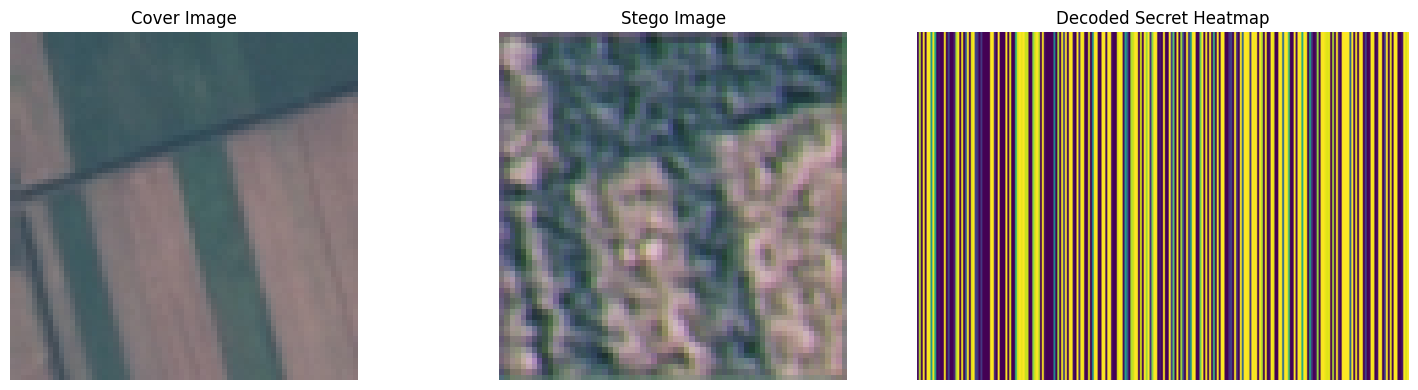

In [71]:
import matplotlib.pyplot as plt
import tensorflow as tf

for sample in val_dataset_payload.take(1):
    cover = sample['cover']
    secret = sample['secret']

    stego = encoder_payload.predict({
        "cover_input": cover,
        "secret_input": secret
    })

    decoded = decoder_payload.predict(stego)

    plt.figure(figsize=(15, 4))

    # Cover
    plt.subplot(1, 3, 1)
    plt.imshow(cover[0])
    plt.title("Cover Image")
    plt.axis('off')

    # Stego
    plt.subplot(1, 3, 2)
    plt.imshow(stego[0])
    plt.title("Stego Image")
    plt.axis('off')

    # Decoded Secret Heatmap
    plt.subplot(1, 3, 3)
    plt.imshow(tf.expand_dims(decoded[0], axis=0), aspect='auto', cmap='viridis')
    plt.title("Decoded Secret Heatmap")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [72]:
# Create a directory to store saved models
import os
os.makedirs("saved_models", exist_ok=True)

# Save payload encoder and decoder
encoder_payload.save("saved_models/encoder_payload_model.keras")
decoder_payload.save("saved_models/decoder_payload_model.keras")

print("✅ Encoder and Decoder models saved to 'saved_models/' folder.")


✅ Encoder and Decoder models saved to 'saved_models/' folder.


In [73]:
# Save detector model
detector_model.save("saved_models/detector_model.keras")


In [75]:
from google.colab import drive
drive.mount('/content/drive')

# Save model to Google Drive
!cp -r saved_models /content/drive/MyDrive/Steganography_Models_Backup/
print("📁 Models copied to Google Drive.")


Mounted at /content/drive
📁 Models copied to Google Drive.
